# Import

In [1]:
# I/O
import os
os.environ["OMP_NUM_THREADS"] = "1" # export OMP_NUM_THREADS=1
os.environ["OPENBLAS_NUM_THREADS"] = "1" # export OPENBLAS_NUM_THREADS=1
os.environ["MKL_NUM_THREADS"] = "1" # export MKL_NUM_THREADS=1
os.environ["VECLIB_MAXIMUM_THREADS"] = "1" # export VECLIB_MAXIMUM_THREADS=1
os.environ["NUMEXPR_NUM_THREADS"] = "1" # export NUMEXPR_NUM_THREADS=1

# Dataset
import numpy as np
import netCDF4 as nc

# Plot
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import matplotlib.animation as animation

# Video
from IPython.display import Video

# Time
import time

In [2]:
def filename_constructor(time_index, case, var):
    return str(f"/data/cloud2023/vvmData{case}/archive{var}-{str(time_index).zfill(6)}.nc")

casenames = ["/rce_walker_15k_05m_p3",
             "/rce_walker_15k_1m_p3",
             "/rce_walker_1k_1m_p3",
             "/rce_walker_1k_2m_p3"]
varnames = ["/exp.C.LandSurface",
            "/exp.C.Surface",
            "/exp.L.Dynamic",
            "/exp.L.Radiation",
            "/exp.L.Thermodynamic"]
iterations = 1200 + 1

In [8]:
def intepolate_1d(x):
    return (x[1:] + x[:-1])/2

def temperature_from_theta(theta, pibar):
    return theta*pibar

def saturated_water_vapor_pressure(temperature):
    temp = np.zeros_like(temperature)
    temp[temperature>96] = 6.112*np.exp((17.67*(temperature[temperature>96]-273.15))/(temperature[temperature>96]+243.5-273.15))
    return temp

def saturated_mixing_ratio(pressure, temperature):
    temp = saturated_water_vapor_pressure(temperature)
    return (0.622*temp)/(pressure - temp)

def dry_lapse_rate(pressure, temperature):
    return 9.8076/1003.5

def moist_lapse_rate(pressure, temperature):
    qvs = saturated_mixing_ratio(pressure, temperature)
    Cp_star = (1003.5 + (6.25e12*qvs)/(461.5*temperature**2)) / (1 + (2.5e6*qvs)/(287.05*temperature))
    return 9.8076/Cp_star

def profiler(height, pressure, temperature, mixing_ratio):
    parcel_temperature = np.zeros_like(temperature)
    parcel_mixing_ratio = np.zeros_like(mixing_ratio)
    parcel_lift = np.diff(height, axis = 0)
    parcel_temperature[0] = temperature[0]
    parcel_mixing_ratio[0] = mixing_ratio[0]
    is_saturated = parcel_mixing_ratio[0] >= saturated_mixing_ratio(pressure[0], parcel_temperature[0])
    
    for levels in range(len(pressure)-1):
        parcel_temperature[levels+1][is_saturated] = (parcel_temperature[levels]-moist_lapse_rate(pressure[levels], parcel_temperature[levels]) * parcel_lift[levels])[is_saturated]
        parcel_temperature[levels+1][~is_saturated] = (parcel_temperature[levels]-9.8076/1003.5 * parcel_lift[levels])[~is_saturated]
        temp = saturated_mixing_ratio(pressure[levels+1], temperature[levels+1])
        is_saturated = parcel_mixing_ratio[levels] >= temp
        parcel_mixing_ratio[levels+1][is_saturated] = temp[is_saturated]
        parcel_mixing_ratio[levels+1][~is_saturated] = parcel_mixing_ratio[levels][~is_saturated]
    return parcel_temperature, parcel_mixing_ratio

In [9]:
# Pick any file
fn = filename_constructor(300, casenames[-1], varnames[-1])
f = nc.Dataset(fn)

# Grids
xc = f.variables["xc"][:]
yc = f.variables["yc"][:]
zc = f.variables["zc"][:]

# Pressure (hPa)
pressure = np.loadtxt(f"/data/cloud2023/vvmData{casenames[-1]}/fort.98", 
                      dtype=float, 
                      skiprows=237,
                      usecols=3,
                      unpack=True,
                      max_rows=46)
pressure = intepolate_1d(pressure)
pressure /= 100 

# Temperature (K)
theta = f.variables["th"][-1]
pibar = np.loadtxt(f"/data/cloud2023/vvmData{casenames[-1]}/fort.98", 
                   dtype=float, 
                   skiprows=237,
                   usecols=4,
                   unpack=True,
                   max_rows=46)
pibar = intepolate_1d(pibar).reshape(-1,1,1)
temperature = temperature_from_theta(theta, pibar)

# Mixing ratio (g/kg)
mixing_ratio = f.variables["qv"][-1] 


zc = np.broadcast_to(zc.reshape(-1,1,1), np.shape(temperature))
pressure = np.broadcast_to(pressure.reshape(-1,1,1), np.shape(temperature))

In [45]:
ct = time.time()
test = profiler(zc, pressure, temperature, mixing_ratio)
cape = np.zeros((128,512))
for i in range(128):
    for j in range(512):
        de = test[0][:,i,j]-temperature[:,i,j]
        el = np.argwhere(de>0)[-1,0]
        cape = -np.trapz(test[0][:el,i,j]-temperature[:el,i,j], np.log(pressure[:el,i,j]))*287.05
print(time.time()-ct)

8.084080934524536


In [13]:
print(test.shape)

(45, 128, 512)


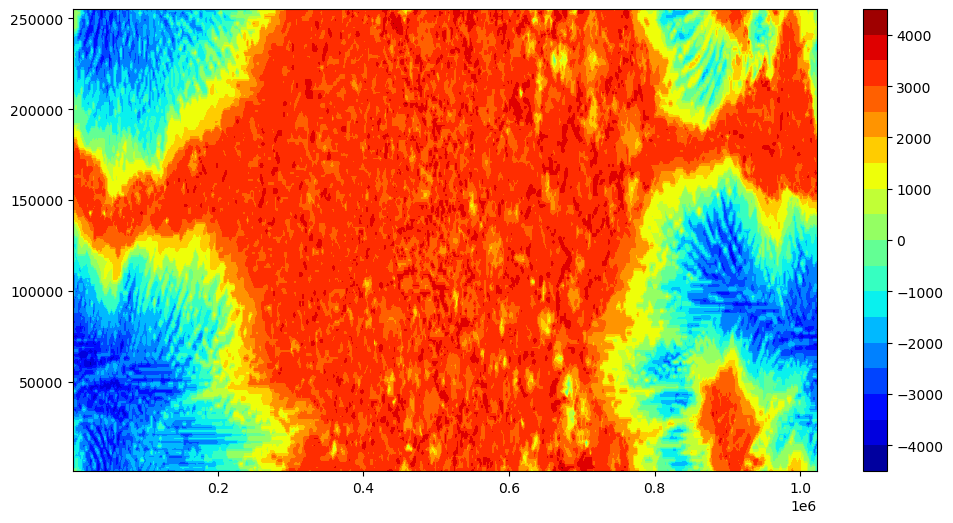

In [46]:
plt.figure(figsize = (12,6))
plt.contourf(xc,yc,-np.trapz((test[0]-temperature )[:-20], np.log(pressure)[:-20], axis = 0)*287.05, levels = 16, cmap = cm.jet)
plt.colorbar()

In [7]:
for item in np.linspace(1,300,300):
    print(item, saturated_water_vapor_pressure(item))

1.0 0.0
2.0 0.0
3.0 0.0
4.0 0.0
5.0 0.0
6.0 0.0
7.0 0.0
8.0 0.0
9.0 0.0
10.0 0.0
11.0 0.0
12.0 0.0
13.0 0.0
14.0 0.0
15.0 0.0
16.0 0.0
17.0 0.0
18.0 0.0
19.0 0.0
20.0 0.0
21.0 0.0
22.0 0.0
23.0 0.0
24.0 0.0
25.0 0.0
26.0 0.0
27.0 0.0
28.0 0.0
29.0 0.0
30.0 0.0
31.0 0.0
32.0 0.0
33.0 0.0
34.0 0.0
35.0 0.0
36.0 0.0
37.0 0.0
38.0 0.0
39.0 0.0
40.0 0.0
41.0 0.0
42.0 0.0
43.0 0.0
44.0 0.0
45.0 0.0
46.0 0.0
47.0 0.0
48.0 0.0
49.0 0.0
50.0 0.0
51.0 8.6540003196703e-80
52.0 7.132348638498508e-76
53.0 2.71537190966674e-72
54.0 5.252086721808204e-69
55.0 5.591705788704523e-66
56.0 3.50741611344835e-63
57.0 1.3736119448362347e-60
58.0 3.5303830462222105e-58
59.0 6.216666995377734e-56
60.0 7.785817183572248e-54
61.0 7.165116653024879e-52
62.0 4.985691305666471e-50
63.0 2.689878262108268e-48
64.0 1.1505227042273823e-46
65.0 3.9789761516346886e-45
66.0 1.1323418011330708e-43
67.0 2.6934852574489133e-42
68.0 5.430927224593538e-41
69.0 9.400001681842438e-40
70.0 1.4125577720653182e-38
71.0 1.861923082

/tmp/ipykernel_96464/3690710138.py:9: RuntimeWarning: overflow encountered in exp
  temp[temperature>50] = 6.112*np.exp((17.67*(temperature-273.15))/(temperature+243.5-273.15))[temperature>50]
